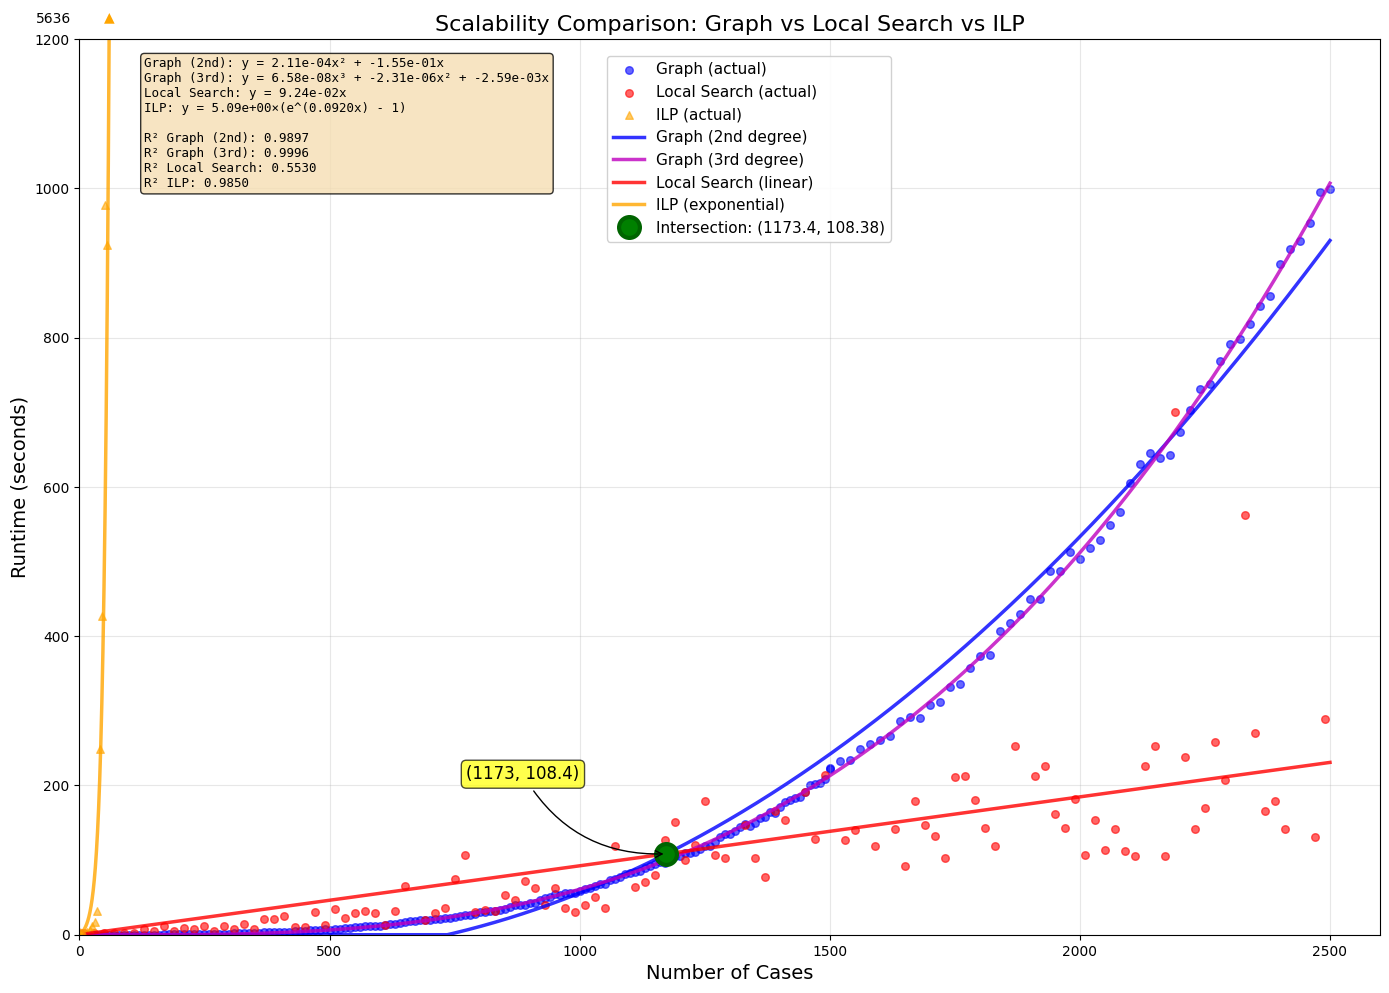

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Read and prepare data
df = pd.read_csv('Scalability_graph_LS_ILP.csv')
df_graph = df[['n_cases', 'runtime_seconds_graph']].dropna()
df_ls = df[['n_cases', 'runtime_seconds_LS']].dropna()
df_ilp = df[['n_cases', 'runtime_seconds_ilp']].dropna()

x_graph = df_graph['n_cases'].values
y_graph = df_graph['runtime_seconds_graph'].values
x_ls = df_ls['n_cases'].values
y_ls = df_ls['runtime_seconds_LS'].values
x_ilp = df_ilp['n_cases'].values
y_ilp = df_ilp['runtime_seconds_ilp'].values

# Create main figure
plt.figure(figsize=(14, 10))

# Fit models for Graph algorithm
X_graph_reshape = x_graph.reshape(-1, 1)

# Fit 2nd degree polynomial
poly_features_2 = PolynomialFeatures(degree=2, include_bias=False)
X_graph_poly_2 = poly_features_2.fit_transform(X_graph_reshape)
poly_model_2 = LinearRegression(fit_intercept=False)
poly_model_2.fit(X_graph_poly_2, y_graph)
b, a = poly_model_2.coef_[0], poly_model_2.coef_[1]
c = 0

# Fit 3rd degree polynomial
poly_features_3 = PolynomialFeatures(degree=3, include_bias=False)
X_graph_poly_3 = poly_features_3.fit_transform(X_graph_reshape)
poly_model_3 = LinearRegression(fit_intercept=False)
poly_model_3.fit(X_graph_poly_3, y_graph)
d3, c3, b3, a3 = poly_model_3.coef_[0], poly_model_3.coef_[1], poly_model_3.coef_[2], 0

# Fit linear model for Local Search
X_ls_reshape = x_ls.reshape(-1, 1)
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_ls_reshape, y_ls)
d = linear_model.coef_[0]
e = 0

# Fit exponential model for ILP - FORCED TO PASS THROUGH (0,0)
def exponential_func_zero(x, a, b):
    """Exponential function that passes through (0,0): y = a * (e^(bx) - 1)"""
    return a * (np.exp(b * x) - 1)

try:
    # Fit exponential curve to ILP data, forcing it through (0,0)
    popt, _ = curve_fit(exponential_func_zero, x_ilp, y_ilp, p0=[1, 0.1], maxfev=10000)
    a_exp, b_exp = popt
    
    # Calculate R² for exponential fit
    y_ilp_pred = exponential_func_zero(x_ilp, a_exp, b_exp)
    r2_ilp = r2_score(y_ilp, y_ilp_pred)
    
    ilp_eq = f'ILP: y = {a_exp:.2e}×(e^({b_exp:.4f}x) - 1)'
    ilp_r2 = f'R² ILP: {r2_ilp:.4f}'
    ilp_fit_success = True
    
except:
    # Fallback to polynomial if exponential fitting fails
    X_ilp_reshape = x_ilp.reshape(-1, 1)
    poly_features_ilp = PolynomialFeatures(degree=3, include_bias=False)
    X_ilp_poly = poly_features_ilp.fit_transform(X_ilp_reshape)
    poly_model_ilp = LinearRegression(fit_intercept=False)
    poly_model_ilp.fit(X_ilp_poly, y_ilp)
    
    r2_ilp = r2_score(y_ilp, poly_model_ilp.predict(X_ilp_poly))
    ilp_eq = f'ILP: 3rd degree polynomial'
    ilp_r2 = f'R² ILP: {r2_ilp:.4f}'
    ilp_fit_success = False

# Plot actual data points
plt.scatter(x_graph, y_graph, alpha=0.6, label='Graph (actual)', color='blue', s=30)
plt.scatter(x_ls, y_ls, alpha=0.6, label='Local Search (actual)', color='red', s=30)
plt.scatter(x_ilp, y_ilp, alpha=0.6, label='ILP (actual)', color='orange', s=30, marker='^')

# Generate smooth curves
x_smooth = np.linspace(10, 2500, 1000)
X_smooth_reshape = x_smooth.reshape(-1, 1)

# Graph algorithm curves
X_smooth_poly_2 = poly_features_2.transform(X_smooth_reshape)
y_poly_2 = poly_model_2.predict(X_smooth_poly_2)
X_smooth_poly_3 = poly_features_3.transform(X_smooth_reshape)
y_poly_3 = poly_model_3.predict(X_smooth_poly_3)

# Local Search curve
y_linear = linear_model.predict(X_smooth_reshape)

# ILP curve - extending from x=0 to show it passes through origin
if ilp_fit_success:
    x_ilp_smooth = np.linspace(0, 80, 1000)  # Start from 0 to show it passes through origin
    y_ilp_smooth = exponential_func_zero(x_ilp_smooth, a_exp, b_exp)
else:
    x_ilp_smooth = np.linspace(x_ilp.min(), x_ilp.max(), 100)
    X_ilp_smooth = poly_features_ilp.transform(x_ilp_smooth.reshape(-1, 1))
    y_ilp_smooth = poly_model_ilp.predict(X_ilp_smooth)

# Ensure non-negative values
y_poly_2 = np.maximum(y_poly_2, 0)
y_poly_3 = np.maximum(y_poly_3, 0)

# Plot fitted curves
valid_idx_2 = y_poly_2 >= 0
if np.any(valid_idx_2):
    plt.plot(x_smooth[valid_idx_2], y_poly_2[valid_idx_2], 'b-', linewidth=2.5, 
             label='Graph (2nd degree)', alpha=0.8)

valid_idx_3 = y_poly_3 >= 0
if np.any(valid_idx_3):
    plt.plot(x_smooth[valid_idx_3], y_poly_3[valid_idx_3], 'm-', linewidth=2.5, 
             label='Graph (3rd degree)', alpha=0.8)
    
plt.plot(x_smooth, y_linear, 'r-', linewidth=2.5, label='Local Search (linear)', alpha=0.8)

# Plot ILP exponential curve
plt.plot(x_ilp_smooth, y_ilp_smooth, color='orange', linewidth=2.5, 
         label='ILP (exponential)', alpha=0.8)

# Add a point at (0,0) to emphasize that ILP curve passes through origin
plt.plot(0, 0, 'o', color='orange', markersize=8, markeredgewidth=2, 
         markeredgecolor='darkorange', alpha=0.8)

# Add the circle as text with a circle symbol
plt.text(0.023, 1.025, '▲', transform=plt.gca().transAxes, clip_on=False,
         fontsize=10, color='orange', ha='center', va='center')

plt.text(-0.02, 1.018, '5636', transform=plt.gca().transAxes,
         fontsize=10, ha='center')

# Add a small indicator showing where on x-axis this would be (if we calculated it)
if ilp_fit_success:
    target_runtime = 5000
    if a_exp > 0 and b_exp > 0:
        x_5000 = np.log(target_runtime / a_exp + 1) / b_exp
        # Convert x-position to axes coordinates
        x_5000_norm = x_5000 / 2600  # Normalize by x-axis range
        if x_5000_norm <= 1.0:  # Only show if within reasonable range
            # Add a small mark at the top of the plot
            plt.plot([x_5000_norm, x_5000_norm], [1.02, 1.10], transform=plt.gca().transAxes,
                    color='orange', linewidth=2, alpha=0.8)

# Calculate and plot intersection points (Graph vs Local Search)
A = a
B = b - d
C = c - e

discriminant = B**2 - 4*A*C

if discriminant >= 0 and A != 0:
    x1 = (-B + np.sqrt(discriminant)) / (2*A)
    x2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    intersections = []
    for x_int in [x1, x2]:
        if 10 <= x_int <= 2500:
            y_int = d * x_int + e
            if y_int > 0:
                intersections.append((x_int, y_int))
    
    for i, (x_int, y_int) in enumerate(intersections):
        plt.plot(x_int, y_int, 'go', markersize=15, markeredgewidth=3, 
                markeredgecolor='darkgreen', label=f'Intersection: ({x_int:.1f}, {y_int:.2f})')
        
        plt.annotate(f'({x_int:.0f}, {y_int:.1f})', 
                    xy=(x_int, y_int), 
                    xytext=(x_int - 400, y_int + 100),
                    fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3"))

# Formatting
plt.xlabel('Number of Cases', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.title('Scalability Comparison: Graph vs Local Search vs ILP', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(0.4, 0.99), fontsize=11, framealpha=0.9)

# Set axis limits to show all data (keeping ylim at 1200)
plt.xlim(0, 2600)
plt.ylim(0, 1200)

# Update equations text box
poly_eq_2 = f'Graph (2nd): y = {a:.2e}x² + {b:.2e}x'
poly_eq_3 = f'Graph (3rd): y = {b3:.2e}x³ + {c3:.2e}x² + {d3:.2e}x'
linear_eq = f'Local Search: y = {d:.2e}x'
equation_text = poly_eq_2 + '\n' + poly_eq_3 + '\n' + linear_eq + '\n' + ilp_eq

r2_poly_2 = r2_score(y_graph, poly_model_2.predict(X_graph_poly_2))
r2_poly_3 = r2_score(y_graph, poly_model_3.predict(X_graph_poly_3))
r2_linear = r2_score(y_ls, linear_model.predict(X_ls_reshape))

equation_text += f'\n\nR² Graph (2nd): {r2_poly_2:.4f}'
equation_text += f'\nR² Graph (3rd): {r2_poly_3:.4f}'
equation_text += f'\nR² Local Search: {r2_linear:.4f}'
equation_text += f'\n{ilp_r2}'

plt.text(0.05, 0.98, equation_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontfamily='monospace', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scalability_comparison_all_methods.png', dpi=150, bbox_inches='tight')
plt.show()